In [1]:
import feather
import pandas as pd
import numpy as np

In [2]:
import gc
import seaborn as sns
%matplotlib inline

In [3]:
df_items = feather.read_dataframe('df/df_items.feather')
df_users = feather.read_dataframe('df/df_users.feather')

In [4]:
df_interactions_1 = feather.read_dataframe('df/df_interactions_1.feather')
df_interactions_2 = feather.read_dataframe('df/df_interactions_2.feather')

In [5]:
df_int = pd.concat([df_interactions_1, df_interactions_2])
del df_interactions_1, df_interactions_2

In [6]:
gc.collect()

7

In [7]:
target_items = pd.read_csv('data/targetItems.csv', header=None)[0]
target_users = pd.read_csv('data/targetUsers.csv').user_id

ti = set(target_items)
tu = set(target_users)

In [8]:
df_items['is_test'] = df_items.item_id.isin(ti)
df_target_items = df_items[df_items.is_test]

In [9]:
df_target_items.created_at.min(), df_target_items.created_at.max()

(Timestamp('2016-08-09 00:00:00'), Timestamp('2017-01-01 00:00:00'))

/home/agrigorev/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


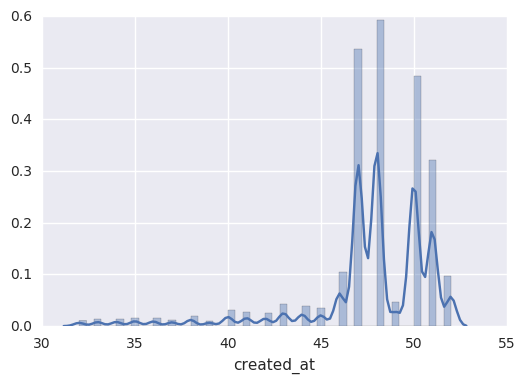

In [10]:
woy = df_target_items.created_at.dt.weekofyear
sns.distplot(woy[~woy.isnull()])

In [11]:
user_int = set(df_int.user_id)
len(tu - user_int) / len(tu)

0.16097006948156067

## let's build a validation set

In [12]:
val_start = pd.to_datetime('2016-08-09')
val_end = pd.to_datetime('2017-01-01')
df_val_cand = df_items[(~df_items.is_test) & (df_items.created_at >= val_start) & (df_items.created_at <= val_end)]

In [13]:
val_ids = set(df_val_cand.item_id.sample(frac=0.01, random_state=1))
len(val_ids)

8169

In [14]:
more_ids = df_val_cand[df_val_cand.created_at.dt.weekofyear >= 46].item_id.sample(frac=0.05, random_state=1)
val_ids.update(more_ids)

In [15]:
len(val_ids)

22167

/home/agrigorev/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


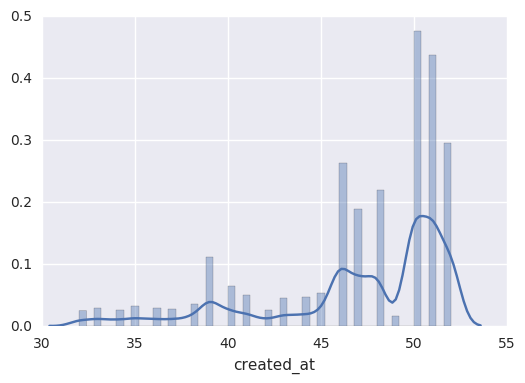

In [16]:
woy = df_items[df_items.item_id.isin(val_ids)].created_at.dt.weekofyear
sns.distplot(woy[~woy.isnull()])

In [21]:
df_int_val = df_int[df_int.item_id.isin(val_ids) & (df_int.interaction_type != 0)]

In [25]:
val_users = set(df_int_val.user_id)
val_users = list(val_users)

np.random.seed(1)
np.random.shuffle(val_users)
val_users = set(val_users[:10000])

rand_users = df_users.user_id.sample(n=65000, random_state=1)
val_users.update(rand_users)

In [26]:
len(val_users)

74541

In [27]:
with open('tmp/val_users2.txt', 'w') as f:
    f.write('user_id\n')
    for u in sorted(val_users):
        f.write('%s\n' % u)

In [32]:
with open('tmp/val_items.txt', 'w') as f:
    for i in sorted(val_ids):
        f.write('%s\n' % i)